## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/autoencoder-for-classification/)) **<font size='3ptx'>Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.</font>**

An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.

The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model. **In this tutorial, you will discover how to develop and evaluate an autoencoder for classification predictive modeling.**
* An autoencoder is a neural network model that can be used to learn a compressed representation of raw data.
* How to train an autoencoder model on a training dataset and save just the encoder part of the model.
* How to use the encoder as a data preparation step when training a machine learning model.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
* <font size='3ptx'>[**Autoencoders for Feature Extraction**](#sect1)</font>
* <font size='3ptx'>[**Autoencoder for Classification**](#sect2)</font>
* <font size='3ptx'>[**Encoder as Data Preparation for Predictive Model**](#sect3)</font>

<a id='sect1'></a>
## <font color='darkblue'>Autoencoders for Feature Extraction</font>
An [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) is a neural network model that seeks to learn a compressed representation of an input.
> An autoencoder is a neural network that is trained to attempt to copy its input to its output. <br/><br/>
> [**— Page 502, Deep Learning, 2016.**](https://amzn.to/3kV7gdV)

They are an unsupervised learning method, although technically, they are trained using supervised learning methods, referred to as self-supervised. Autoencoders are typically trained as part of a broader model that attempts to recreate the input.

For example:
```python
X = model.predict(X)
```
The design of the autoencoder model purposefully makes this challenging by restricting the architecture to a bottleneck at the midpoint of the model, from which the reconstruction of the input data is performed.

There are many types of autoencoders, and their use varies, but perhaps the more common use is as a learned or automatic feature extraction model.

In this case, once the model is fit, the reconstruction aspect of the model can be discarded and the model up to the point of the bottleneck can be used. The output of the model at the bottleneck is a fixed-length vector that provides a compressed representation of the input data.

> Usually they are restricted in ways that allow them to copy only approximately, and to copy only input that resembles the training data. Because the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data. <br/><br/>
> [— Page 502, Deep Learning, 2016.](https://amzn.to/3kV7gdV)

Input data from the domain can then be provided to the model and **the output of the model at the bottleneck can be used as a feature vector in a supervised learning model, for visualization, or more generally for dimensionality reduction.**

Next, let’s explore how we might develop an autoencoder for feature extraction on a classification predictive modeling problem.

In [25]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

<a id='sect2'></a>
## <font color='darkblue'>Autoencoder for Classification</font>
In this section, we will develop an autoencoder to learn a compressed representation of the input features for a classification predictive modeling problem. **First, let’s define a classification predictive modeling problem.**

We will use the [make_classification() scikit-learn function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) to define a synthetic binary (2-class) classification task with 100 input features (columns) and 1,000 examples (rows). Importantly, we will define the problem in such a way that most of the input variables are redundant (90 of the 100 or 90 percent), **allowing the autoencoder later to learn a useful compressed representation.**

The example below defines the dataset and summarizes its shape.

In [2]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)

# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


Next, we will develop a Multilayer Perceptron (MLP) autoencoder model. The model will take all of the input columns, then output the same values. It will learn to recreate the input pattern exactly.

**The autoencoder consists of two parts: the encoder and the decoder.** The encoder learns how to interpret the input and compress it to an internal representation defined by the bottleneck layer. The decoder takes the output of the encoder (the bottleneck layer) and attempts to recreate the input.

Once the autoencoder is trained, the decoder is discarded and **we only keep the encoder and use it to compress examples of input to vectors output by the bottleneck layer.**

In this first autoencoder, we won’t compress the input at all and will **use a bottleneck layer the same size as the input. This should be an easy problem that the model will learn nearly perfectly and is intended to confirm our model is implemented correctly.**

Prior to defining and fitting the model, we will **split the data into train and test sets and scale the input data by normalizing the values to the range 0-1, a good practice with MLPs.**

In [3]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

We will define the encoder to have two hidden layers, the first with two times the number of inputs (e.g. 200) and the second with the same number of inputs (100), followed by the bottleneck layer with the same number of inputs as the dataset (100).

**To ensure the model learns well, we will use batch normalization and leaky [ReLU activation](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/).**

In [5]:
# Define encoder
n_inputs = X.shape[1]
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

The decoder will be defined with a similar structure, although in reverse.

It will have two hidden layers, the first with the number of inputs in the dataset (e.g. 100) and the second with double the number of inputs (e.g. 200). The output layer will have the same number of nodes as there are columns in the input data and will use a linear activation function to output numeric values.

In [6]:
# Define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

The model will be fit using the efficient Adam version of stochastic gradient descent and minimizes the mean squared error, given that reconstruction is a type of multi-output regression problem.

In [7]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

We can plot the layers in the autoencoder model to get a feeling for how the data flows through the model.

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)              

Next, we can train the model to reproduce the input and keep track of the performance of the model on the hold-out test set.

In [9]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/200
42/42 - 0s - loss: 0.2339 - val_loss: 0.2048
Epoch 2/200
42/42 - 0s - loss: 0.0352 - val_loss: 0.1121
Epoch 3/200
42/42 - 0s - loss: 0.0234 - val_loss: 0.0572
Epoch 4/200
42/42 - 0s - loss: 0.0192 - val_loss: 0.0330
Epoch 5/200
42/42 - 0s - loss: 0.0165 - val_loss: 0.0214
Epoch 6/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0144
Epoch 7/200
42/42 - 0s - loss: 0.0126 - val_loss: 0.0121
Epoch 8/200
42/42 - 0s - loss: 0.0116 - val_loss: 0.0090
Epoch 9/200
42/42 - 0s - loss: 0.0112 - val_loss: 0.0074
Epoch 10/200
42/42 - 0s - loss: 0.0118 - val_loss: 0.0079
Epoch 11/200
42/42 - 0s - loss: 0.0106 - val_loss: 0.0066
Epoch 12/200
42/42 - 0s - loss: 0.0097 - val_loss: 0.0053
Epoch 13/200
42/42 - 0s - loss: 0.0092 - val_loss: 0.0058
Epoch 14/200
42/42 - 0s - loss: 0.0088 - val_loss: 0.0055
Epoch 15/200
42/42 - 0s - loss: 0.0091 - val_loss: 0.0068
Epoch 16/200
42/42 - 0s - loss: 0.0089 - val_loss: 0.0067
Epoch 17/200
42/42 - 0s - loss: 0.0086 - val_loss: 0.0053
Epoch 18/200
42/42 - 0s

Epoch 142/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0014
Epoch 143/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0015
Epoch 144/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0020
Epoch 145/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0013
Epoch 146/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0010
Epoch 147/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0013
Epoch 148/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0014
Epoch 149/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0019
Epoch 150/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0015
Epoch 151/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0014
Epoch 152/200
42/42 - 0s - loss: 0.0030 - val_loss: 9.5503e-04
Epoch 153/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0021
Epoch 154/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0012
Epoch 155/200
42/42 - 0s - loss: 0.0032 - val_loss: 0.0011
Epoch 156/200
42/42 - 0s - loss: 0.0032 - val_loss: 0.0015
Epoch 157/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0015
Epoch 158/200
42/42 - 0s - loss: 0.0033 - val_loss: 

After training, we can plot the learning curves for the train and test sets to confirm the model learned the reconstruction problem well.

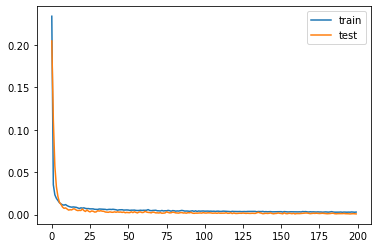

In [10]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Finally, we can save the encoder model for use later, if desired.

In [12]:
# Define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# Save the encoder to file
encoder.save('encoder.h5')

So far, so good. We know how to develop an autoencoder without compression. Next, let’s change the configuration of the model so that the bottleneck layer has half the number of nodes (e.g. 50).

In [16]:
def get_autoencoder(n_inputs=X.shape[1], n_bottleneck=round(float(X.shape[1])/2.0)):
    visible = Input(shape=(n_inputs,))

    # encoder level 1
    e = Dense(n_inputs*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    # encoder level 2
    e = Dense(n_inputs)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    # bottleneck
    bottleneck = Dense(n_bottleneck)(e)
    
    # Define decoder, level 1
    d = Dense(n_inputs)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    # decoder level 2
    d = Dense(n_inputs*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    # output layer
    output = Dense(n_inputs, activation='linear')(d)

    # define autoencoder model
    model = Model(inputs=visible, outputs=output)
    
    # compile autoencoder model
    model.compile(optimizer='adam', loss='mse')
    
    return model, visible, bottleneck

model, visible, bottleneck = get_autoencoder()
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 200)               20200     
_________________________________________________________________
batch_normalization_12 (Batc (None, 200)               800       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               20100     
_________________________________________________________________
batch_normalization_13 (Batc (None, 100)               400       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 100)             

In [17]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/200
42/42 - 0s - loss: 0.2276 - val_loss: 0.1733
Epoch 2/200
42/42 - 0s - loss: 0.0371 - val_loss: 0.1089
Epoch 3/200
42/42 - 0s - loss: 0.0240 - val_loss: 0.0554
Epoch 4/200
42/42 - 0s - loss: 0.0191 - val_loss: 0.0317
Epoch 5/200
42/42 - 0s - loss: 0.0156 - val_loss: 0.0206
Epoch 6/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0140
Epoch 7/200
42/42 - 0s - loss: 0.0128 - val_loss: 0.0109
Epoch 8/200
42/42 - 0s - loss: 0.0125 - val_loss: 0.0095
Epoch 9/200
42/42 - 0s - loss: 0.0114 - val_loss: 0.0075
Epoch 10/200
42/42 - 0s - loss: 0.0112 - val_loss: 0.0079
Epoch 11/200
42/42 - 0s - loss: 0.0112 - val_loss: 0.0062
Epoch 12/200
42/42 - 0s - loss: 0.0094 - val_loss: 0.0053
Epoch 13/200
42/42 - 0s - loss: 0.0086 - val_loss: 0.0047
Epoch 14/200
42/42 - 0s - loss: 0.0082 - val_loss: 0.0044
Epoch 15/200
42/42 - 0s - loss: 0.0087 - val_loss: 0.0046
Epoch 16/200
42/42 - 0s - loss: 0.0085 - val_loss: 0.0061
Epoch 17/200
42/42 - 0s - loss: 0.0091 - val_loss: 0.0048
Epoch 18/200
42/42 - 0s

Epoch 142/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0014
Epoch 143/200
42/42 - 0s - loss: 0.0032 - val_loss: 0.0017
Epoch 144/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 145/200
42/42 - 0s - loss: 0.0039 - val_loss: 0.0014
Epoch 146/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0022
Epoch 147/200
42/42 - 0s - loss: 0.0037 - val_loss: 0.0018
Epoch 148/200
42/42 - 0s - loss: 0.0032 - val_loss: 0.0018
Epoch 149/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0023
Epoch 150/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0017
Epoch 151/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0017
Epoch 152/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0016
Epoch 153/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0016
Epoch 154/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0017
Epoch 155/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0019
Epoch 156/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0012
Epoch 157/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0014
Epoch 158/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.00

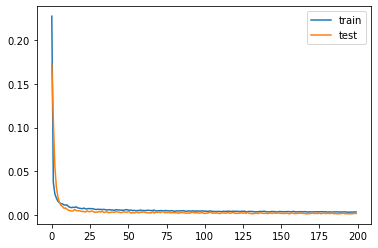

In [18]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# save the encoder to file
encoder.save('encoder.h5')

The trained encoder is saved to the file “encoder.h5” that we can load and use later. Next, let’s explore how we might use the trained encoder model.

<a id='sect3'></a>
## <font color='darkblue'>Encoder as Data Preparation for Predictive Model</font>
In this section, we will use the trained encoder from the autoencoder to compress input data and train a different predictive model.

**First, let’s establish a baseline in performance on this problem.** This is important as if the performance of a model is not improved by the compressed encoding, then the compressed encoding does not add value to the project and should not be used.

We can train a logistic regression model on the training dataset directly and evaluate the performance of the model on the holdout test set.

In [22]:
# Define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)

# Split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# Define model
model = LogisticRegression()

# fit model on training set
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


In this case, we can see that the model achieves a classification accuracy of about 89.3 percent. **We would hope and expect that a logistic regression model fit on an encoded version of the input to achieve better accuracy for the encoding to be considered useful.**

We can update the example to first encode the data using the encoder model trained in the previous section. First, we can load the trained encoder model from the file.

In [26]:
# load the model from file
encoder = load_model('encoder.h5')

We can then use the encoder to transform the raw input data (e.g. 100 columns) into bottleneck vectors (e.g. 50 element vectors). This process can be applied to the train and test datasets.

In [27]:
# encode the train data
X_train_encode = encoder.predict(X_train)

# encode the test data
X_test_encode = encoder.predict(X_test)

In [28]:
X_train_encode.shape

(670, 50)

We can then use this encoded data to train and evaluate the logistic regression model, as before.

In [29]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9212121212121213


In this case, we can see that the model achieves a classification accuracy of about 92.1 percent. This is a better classification accuracy than the same model evaluated on the raw dataset, suggesting that the encoding is helpful for our chosen model and test harness.